Coisas para se fazer:
1. Criar um teste para identificar a correlação entre as variáveis preditoras;
2. Testar diferentes métodos de oversampling e undersampling
3. Criar uma simulação que gera um classificador para cada train/test split e fornece uma decisão   baseado nessa de classificadores gerados
4. Analisar os resultados de diferentes classificadores para indentificar as características de que 
exemplos os classificadores estão divergindo

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, PowerTransformer
from sklearn.metrics import make_scorer,f1_score,accuracy_score,confusion_matrix,roc_auc_score,roc_curve, recall_score,precision_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from scipy.stats import f_oneway, kruskal,chi2_contingency
import scikit_posthocs as sp 
    

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE 
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection



def minha_metrica(y_true, y_pred):
    threshold = 0.5  # Defina o threshold desejado
    

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

def geo_score(y_true, y_pred):
    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred==1))
    fn = np.sum((y_true == 1) & (y_pred==0))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred==0))
    fp = np.sum((y_true == 0) & (y_pred==1))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

def minha_metrica_c(y_true, y_pred,threshold = 0.5):
    

    # Calcule o true positive rate para o threshold dado
    tp = np.sum((y_true == 1) & (y_pred >= threshold))
    fn = np.sum((y_true == 1) & (y_pred < threshold))
    tpr = tp / (tp + fn)

    # Calcule o true negative rate para o threshold dado
    tn = np.sum((y_true == 0) & (y_pred < threshold))
    fp = np.sum((y_true == 0) & (y_pred >= threshold))
    tnr = tn / (tn + fp)

    # Calcule o produto dos passos 1 e 2
    product = tpr * tnr

    # Retorne a raiz quadrada do passo 3
    return np.sqrt(product)

def get_scores(y_true_tr,y_pred_tr,y_true_ts,y_pred_ts,scorers=["roc_auc_score","accuracy_score","precision_score","recall_score","f1_score"]):
    nomes, vtest,vtrain = [],[],[]

    fpr, tpr, thresholds = roc_curve(y_true_tr, y_pred_tr)
    distances = (fpr - 0)**2 + (tpr - 1)**2
    index = distances.argmin()
    corte = thresholds[index]
    fprts, tprts, thresholdsts = roc_curve(y_true_ts, y_pred_ts)

    for sc in scorers:
        if sc.__name__ in ["roc_auc_curve"]:
            vtest.append(sc(y_true_ts,y_pred_ts))
            vtrain.append(sc(y_true_tr,y_pred_tr))
            nomes.append(sc.__name__)
        elif sc.__name__ in ["minha_metrica_c"]:
            vtest.append(sc(y_true_ts, y_pred_ts,threshold = corte))
            vtrain.append(sc(y_true_tr, y_pred_tr,threshold = corte))
            nomes.append(sc.__name__)
        else:
            vtest.append(sc(y_true_ts,y_pred_ts>=corte))
            vtrain.append(sc(y_true_tr,y_pred_tr>=corte))
            nomes.append(sc.__name__)    
    
    metricas = pd.DataFrame({"metrica":nomes,"valor no treino":vtrain,"valor no teste":vtest})
    roc_curve_train = {"fpr":fpr,"tpr":tpr,"thresholds":thresholds,"corte":corte} 
    roc_curve_test = {"fpr":fprts,"tpr":tprts,"thresholds":thresholdsts}
    cm1 = confusion_matrix(y_pred=y_pred_ts>=corte,y_true=y_true_ts)
    cm2 = confusion_matrix(y_pred=y_pred_ts>=corte,y_true=y_true_ts,normalize='true')
    cm = pd.DataFrame({"pred_0":[cm1[0][0],cm1[1][0]],"pred_1":[cm1[0][1],cm1[1][1]],"predn_0":[cm2[0][0],cm2[1][0]],"predn_1":[cm2[0][1],cm2[1][1]]},index=["true 0","true_1"])
    res = {"metricas":metricas,"roc_curve_train":roc_curve_train,"roc_curve_test":roc_curve_test,"melhor":[fpr[index],tpr[index],corte],"confusion_matrix":cm}
    return res

def meu_enconder(data,columns,target,split = False,rnd_state=None):
    mapa = {}
    if split:
        data_train,data_test = train_test_split(data,test_size=0.2,stratify=data[target],random_state=rnd_state)
        for cl in columns:
            # contagemp = data_train.groupby(cl)[target].value_counts(normalize=True).unstack().fillna(0)
            contagemp = data_train.groupby(cl)[target].value_counts(normalize=True).unstack()
            contagemp["log"] = np.log(contagemp[1]/contagemp[0])
            idx = contagemp.sort_values(by='log',ascending=False).index
            mapeamento = {v:i for i,v in enumerate(idx)}
            mapeamento_inverso = {i:v for i,v in enumerate(idx)} 
            data_train[cl] = data_train[cl].map(mapeamento)
            data_test[cl] = data_test[cl].map(mapeamento)
            mapa[cl]= {"mapa":mapeamento,"mapa_inverso":mapeamento_inverso}
    
        return {"train":data_train,"test":data_test,"mapas":mapa}
    else:
        ndata = data.copy()
        for cl in columns:
            contagemp = data.groupby(cl)[target].value_counts(normalize=True).unstack()
            contagemp["log"] = np.log(contagemp[1]/contagemp[0])
            idx = contagemp.sort_values(by='log',ascending=False).index
            mapeamento = {v:i for i,v in enumerate(idx)} 
            mapeamento_inverso = {i:v for i,v in enumerate(idx)} 
            ndata[cl] = data[cl].map(mapeamento).astype(int)
            mapa[cl]= {"mapa":mapeamento,"mapa_inverso":mapeamento_inverso}
        return {"data":ndata,"mapas":mapa}

def categorizar(data,columns):
    ndata = data.copy()
    intervalos = {}
    for cl in columns:
        if data[cl].dtypes in [np.int64,np.int32,np.float64]:
            categories = pd.qcut(data[cl],10,duplicates='drop')
            labels, unicos = pd.factorize(categories, sort=True)
            mapa = {f'{i}': [un.left, un.right] for i, un in enumerate(unicos)}
            intervalos[cl] = mapa
            ndata[f"{cl}_cat"] = labels
    return {"data":ndata,"intervalos":intervalos}

def significancia(data,predictors,target,alpha=0.1):
    pval,tval,sigval = [],[],[]
    myvars = list(predictors.keys())
    for cl in myvars:
        if predictors[cl]:
            contingency_table = pd.crosstab(data[cl], data[target])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            pval.append(p)
            tval.append(chi2)
            sigval.append(p<alpha)
        else:
            groups = []
            gpstat = data.groupby(target)
            for key in gpstat.groups.keys():
                groups.append(gpstat.get_group(key)[cl])
            f_statistic, p = kruskal(*groups)
            pval.append(p)
            tval.append(f_statistic)
            sigval.append(p<alpha)
    significantvar = list([myvars[i] for i,v in enumerate(sigval) if v])
    stats = pd.DataFrame({"variable":myvars,"test-value":tval,"p-value":pval,"significance":sigval})
    return {"stats":stats,"significantes":significantvar}

def simulador(estimator,data,predictors,target,nsim,metricas=[geo_score,f1_score,accuracy_score,roc_auc_score]):
    metricasval = np.zeros((nsim,len(metricas)))
    truepos,trueneg = [],[]
    res = {}
    for i in range(nsim):
        data_train,data_test = train_test_split(data,test_size=0.2, stratify=data[target])
        X_train,y_train = data_train[predictors],data_train[target]
        X_test,y_test = data_test[predictors],data_test[target]

        bests = estimator.fit(X_train,y_train)
        y_pred_ts = bests.predict_proba(X_test)[:,1]
        y_pred_tr = bests.predict_proba(X_train)[:,1]

        fpr, tpr, thresholds = roc_curve(y_train, y_pred_tr)
        distances = (fpr - 0)**2 + (tpr - 1)**2
        index = distances.argmin()
        corte = thresholds[index]
        cm = confusion_matrix(y_pred=y_pred_ts>=corte,y_true=y_test,normalize='true')
        truepos.append(cm[1][1])
        trueneg.append(cm[0][0])
        for j,mtr in enumerate(metricas):
            if mtr.__name__ in ["roc_auc_curve"]:
                metricasval[i,j] = mtr(y_test,y_pred_ts)
            else:
                metricasval[i,j] = mtr(y_test,y_pred_ts>=corte)
    
    res["tpr"] = truepos
    res["tnr"] = trueneg
    for j,mtr in enumerate(metricas):
        res[mtr.__name__] = metricasval[:,j]
    return res

def minha_anova(tabela,alpha = 0.05):
    h_statistic, p_value = kruskal(*tabela)
    if p_value>alpha:
        return  {"stats":h_statistic,"p_value":p_value}
    
    else:
        pvals = sp.posthoc_conover(tabela,p_adjust='holm').to_numpy()
        ddif = {}
        for i in range(pvals.shape[0]):
            dff,deq = [],[]
            for j in range(pvals.shape[1]):
                if pvals[i,j]<0.05:
                    dff.append(j)
                else:
                    deq.append(j)
            ddif[i]={"igual_idx":deq,"diferente_idx":dff}
        
        return {"stats":ddif,"p_value":pvals}

In [ ]:
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns[:-1])

categoricalvar = {cl:data[cl].dtypes == np.object0 for cl in original_columns} 

categs = categorizar(data=data,columns=[cl for cl in original_columns if not categoricalvar[cl]])
data = categs["data"]

encodar = [cl for cl in original_columns if categoricalvar[cl]]+[f"{cl}_cat" for cl in original_columns if not categoricalvar[cl]]
encodado = meu_enconder(data=data,columns=encodar,target=target,split=True)
data_train,data_test = encodado["train"],encodado["test"]

res = significancia(data,categoricalvar,target)
predictors = res["significantes"]

X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]

my_scorer,my_scorer_m = make_scorer(roc_auc_score,greater_is_better=True), make_scorer(minha_metrica,greater_is_better=True)

In [ ]:
np.corrcoef(data_train['no_exa_scheduled_previous_year'],data_train['no_ns_cons_previous_year'])

In [ ]:
var_cat = ['age_cat', 'distance_cat', 'lead_time_cat',
       'no_cons_scheduled_previous_year_cat', 'no_ns_cons_previous_year_cat',
       'no_exa_scheduled_previous_year_cat', 'no_ns_exa_previous_year_cat']
for cl in var_cat:
    contagemp = data_train.groupby(cl)[target].value_counts(normalize=True).unstack().fillna(0)
    idx = contagemp.sort_values(by=1,ascending=False).index
    mapeamento = {v:i for i,v in enumerate(idx)} 
    data_train[f"{cl}_cat2"] = data_train[cl].map(mapeamento).astype(int)
    data_test[f"{cl}_cat2"] = data_test[cl].map(mapeamento).astype(int)


In [ ]:
fig,ax = plt.subplots(3,3)
ax = ax.flatten()
i = 0
for cl in predictors:
    sns.histplot(x=cl,data=data_train,ax=ax[i])
    i = i+1
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(3,2)
ax = ax.flatten()
i = 0
for cl in predictors:
    if categoricalvar[cl]:
        contagemp = data_train.groupby(cl)[target].value_counts(normalize=True).unstack().fillna(0)
        sns.scatterplot(x=cl,y=1,data=contagemp,ax=ax[i])
        i = i+1

plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(3,2)
ax = ax.flatten()
i = 0
for cl in predictors:
    if not categoricalvar[cl]:
        contagemp = data_train.groupby(f"{cl}_cat")[target].value_counts(normalize=True).unstack().fillna(0)
        sns.scatterplot(x=f"{cl}_cat",y=1,data=contagemp,ax=ax[i],color="red")
        sns.lineplot(x=f"{cl}_cat",y=1,data=contagemp,ax=ax[i],linestyle='dashed')
        i = i+1

plt.tight_layout()
plt.show()

In [ ]:
cls = "age_cat"
grau = 2
contagemp = data_train.groupby(cls)[target].value_counts(normalize=True).unstack().fillna(0)
aa = np.polyfit(np.array(contagemp.index),np.array(contagemp[1]),grau)
xxp = np.array(contagemp.index)
yyp  = np.sum([par*xxp**(grau-i) for i,par in enumerate(aa)],axis=0)
sns.scatterplot(x=cls,y=1,data=contagemp,color="red")
sns.lineplot(x=cls,y=1,data=contagemp,linestyle='dashed')
sns.lineplot(x=xxp,y=yyp)

data_train["age_2"] = np.sum([par*data_train["age"]**(grau-i) for i,par in enumerate(aa)],axis=0)
data_test["age_2"] = np.sum([par*data_test["age"]**(grau-i) for i,par in enumerate(aa)],axis=0)

cls = "distance_cat"
grau = 2
contagemp = data_train.groupby(cls)[target].value_counts(normalize=True).unstack().fillna(0)
aa = np.polyfit(np.array(contagemp.index),np.array(contagemp[1]),grau)
xxp = np.array(contagemp.index)
yyp  = np.sum([par*xxp**(grau-i) for i,par in enumerate(aa)],axis=0)
sns.scatterplot(x=cls,y=1,data=contagemp,color="red")
sns.lineplot(x=cls,y=1,data=contagemp,linestyle='dashed')
sns.lineplot(x=xxp,y=yyp)

data_train["distance_2"] = np.sum([par*data_train["distance"]**(grau-i) for i,par in enumerate(aa)],axis=0)
data_test["distance_2"] = np.sum([par*data_test["distance"]**(grau-i) for i,par in enumerate(aa)],axis=0)


In [ ]:
predictors


In [ ]:
# KNN Classifier 
vizinhos = 35
pipe = Pipeline([('escala',StandardScaler()),('modelo', KNeighborsClassifier(n_neighbors=vizinhos))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=3, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

# bests = pipe.fit(X_train, y_train)

# coeficientes = pd.DataFrame({"variável":pipe.named_steps["poly"].get_feature_names_out().ravel,"coeficientes":bests.named_steps["modelo"].coef_.ravel()})
# print(f"{coeficientes}\n")

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


In [ ]:
# Logistic Regression

pipe = Pipeline([('poly',PolynomialFeatures(5)),('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1.0e-5,max_iter=1000000))])

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1.0e-15,max_iter=1000000))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=3, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

# bests = pipe.fit(X_train, y_train)

# coeficientes = pd.DataFrame({"variável":pipe.named_steps["poly"].get_feature_names_out().ravel,"coeficientes":bests.named_steps["modelo"].coef_.ravel()})
# print(f"{coeficientes}\n")

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# SGD Classifier
# pipe = Pipeline([('poly',PolynomialFeatures(2)),('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',C = 1.0e-2,max_iter=1000000))])

alpha = 1e-0
max_iter = 5000
loss = "squared_hinge"
penalty = "l2"
pipe = Pipeline([('escala',StandardScaler()),('modelo', SGDClassifier(loss=loss,penalty=penalty,class_weight='balanced',alpha = alpha,max_iter=max_iter))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=3, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

# bests = pipe.fit(X_train, y_train)

# coeficientes = pd.DataFrame({"variável":pipe.named_steps["poly"].get_feature_names_out().ravel,"coeficientes":bests.named_steps["modelo"].coef_.ravel()})
# print(f"{coeficientes}\n")

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
#Logistic Regression GridSearch
param_grid = {
    "modelo__C" :np.geomspace(1e-8,1e+2,50),
    "poly__degree" :[1,2,4]
}
pipe = Pipeline([('poly',PolynomialFeatures()),('escala',MinMaxScaler()),('modelo', LogisticRegression(penalty='l2',class_weight='balanced',max_iter=1000000))])

search = GridSearchCV(pipe, param_grid,scoring = my_scorer, cv = 3, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

print("--melhor escore no cv--")
print(search.best_score_)

print("\n--parâmetros de melhor escore no cv--") 
print(search.best_params_)

# coeficientes = pd.DataFrame({"variável":predictors,"coeficientes":bests.named_steps["modelo"].coef_})
# print(f"\n{coeficientes}")

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)

res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"\n{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
#SVC Classifier

ga = 'auto'
dg = 1

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='poly',class_weight='balanced',degree=dg,gamma=ga))])
pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='rbf',class_weight='balanced',degree=dg,gamma=ga))])


search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=7, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


In [ ]:
# GridSearch SVC Classifier
param_grid = {
    "modelo__gamma" : list(np.geomspace(1e-5,1e+0,5))+['auto','scale'],
    "modelo__degree":[1,2],
    "modelo__kernel": ["poly",'rbf']
}

# pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(kernel='poly',class_weight='balanced'))])

pipe = Pipeline([('escala',MinMaxScaler()),('modelo', SVC(class_weight='balanced'))])


search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 5, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

y_pred_test = bests.decision_function(X_test)
y_pred_train = bests.decision_function(X_train)

print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")


In [ ]:
# Random Forest

n_estimators = 5
max_features = "log2"
max_depth = 2

pipe = Pipeline([('modelo', RandomForestClassifier(n_estimators=n_estimators,max_features=max_features,class_weight='balanced',max_depth=max_depth))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=7, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# GridSearch Random Forest
param_grid = {
    'modelo__n_estimators': [2*n+1 for n in range(2,10)],
    'modelo__max_features':["sqrt", "log2"],
    'modelo__max_depth': [2,3,4,5,7]
    }

pipe = Pipeline([('modelo', RandomForestClassifier(class_weight='balanced'))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 5, n_jobs=-1)
search.fit(X_train, y_train)
bests = search.best_estimator_

print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# GridSearch Random Forest com SAMPLING
param_grid = {
    'modelo__n_estimators': [2*n+1 for n in range(2,50)],
    'modelo__max_features':["sqrt", "log2"],
    'modelo__max_depth': [2,3,4]
    }

pipe = Pipeline([('modelo', RandomForestClassifier(class_weight='balanced'))])

search = GridSearchCV(pipe, param_grid, scoring = my_scorer, cv = 5, n_jobs=-1)

sampler = RandomOverSampler()
X_trans,y_trans = sampler.fit_resample(X_train, y_train)

search.fit(X_trans, y_trans)
bests = search.best_estimator_

print(f"melhor score cv:\n{search.best_score_}\n")
print(f"parâmetros melhor score cv:\n{search.best_params_}\n")

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [ ]:
# cross_validade Random Forest com SAMPLING 
n_estimators = 55
max_features = "log2"
max_depth = 3
criterion = 'log_loss'

pipe = Pipeline([('modelo', RandomForestClassifier(criterion=criterion,n_estimators=n_estimators,max_features=max_features,class_weight='balanced',max_depth=max_depth))])

sampler = SMOTE()
X_trans,y_trans = sampler.fit_resample(X_train, y_train)

search = cross_validate(pipe, X_trans, y_trans, scoring=my_scorer_m, cv=5, return_estimator=True,return_train_score=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [3]:
# simulations for RandomForest
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns[:-1])
categoricalvar = {cl:data[cl].dtypes == np.object0 for cl in original_columns} 
categs = categorizar(data=data,columns=[cl for cl in original_columns if not categoricalvar[cl]])
data = categs["data"]

encodar = [cl for cl in original_columns if categoricalvar[cl]]+[f"{cl}_cat" for cl in original_columns if not categoricalvar[cl]]
encodado = meu_enconder(data=data,columns=encodar,target=target,split=False)

data = encodado["data"]
res = significancia(data,categoricalvar,target)
predictors = res["significantes"]

from itertools import product
n_est = [9,15,25,55,75]
max_features = ["log2","sqrt"]
max_depth = [2,3,5]
crit = ['log_loss']

combinations = list(product(n_est, max_depth,max_features,crit))

simulacoes =  pd.DataFrame()
for k,v in enumerate(combinations):
    print(f"modelo {k+1} de {len(combinations)}")
    pipe = Pipeline([('modelo', RandomForestClassifier(criterion=v[3],n_estimators=v[0],max_features=v[2],class_weight='balanced',max_depth=v[1]))])
    res = simulador(pipe,data,predictors,target,50)
    simulacoes[f"sim_{k+1}"] = res["geo_score"]

analise_sim = minha_anova(simulacoes.to_numpy().T,alpha=0.05)

data_train,data_test = train_test_split(data,test_size=0.2, stratify=data[target])
X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]
my_scorer,my_scorer_m = make_scorer(roc_auc_score,greater_is_better=True), make_scorer(minha_metrica,greater_is_better=True)


idx = simulacoes.median().argmax()
esc = analise_sim["stats"][idx]["igual_idx"][0]
v = combinations[esc]
pipe = Pipeline([('modelo', RandomForestClassifier(criterion=v[3],n_estimators=v[0],max_features=v[2],class_weight='balanced',max_depth=v[1]))])
search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=7, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()


modelo 1 de 30
modelo 2 de 30
modelo 3 de 30
modelo 4 de 30
modelo 5 de 30
modelo 6 de 30
modelo 7 de 30
modelo 8 de 30
modelo 9 de 30
modelo 10 de 30
modelo 11 de 30
modelo 12 de 30
modelo 13 de 30
modelo 14 de 30
modelo 15 de 30
modelo 16 de 30
modelo 17 de 30
modelo 18 de 30
modelo 19 de 30
modelo 20 de 30
modelo 21 de 30
modelo 22 de 30
modelo 23 de 30
modelo 24 de 30
modelo 25 de 30
modelo 26 de 30
modelo 27 de 30
modelo 28 de 30
modelo 29 de 30
modelo 30 de 30


In [ ]:
# simulations for KNN
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns[:-1])
categoricalvar = {cl:data[cl].dtypes == np.object0 for cl in original_columns} 
categs = categorizar(data=data,columns=[cl for cl in original_columns if not categoricalvar[cl]])
data = categs["data"]

encodar = [cl for cl in original_columns if categoricalvar[cl]]+[f"{cl}_cat" for cl in original_columns if not categoricalvar[cl]]
encodado = meu_enconder(data=data,columns=encodar,target=target,split=False)

data = encodado["data"]
res = significancia(data,categoricalvar,target)
predictors = res["significantes"]

from itertools import product
viz = list(range(40,141,10))
pesos = ["uniform"]
escalas = [MinMaxScaler(),StandardScaler()]

combinations = list(product(viz,pesos,escalas))

simulacoes =  pd.DataFrame()
for k,v in enumerate(combinations):
    print(f"modelo {k+1} de {len(combinations)}")
    pipe = Pipeline([('escala',v[2]),('modelo', KNeighborsClassifier(n_neighbors=v[0],weights=v[1]))])
    res = simulador(pipe,data,predictors,target,50)
    simulacoes[f"sim_{k+1}"] = res["geo_score"]

analise_sim = minha_anova(simulacoes.to_numpy().T,alpha=0.05)

data_train,data_test = train_test_split(data,test_size=0.2, stratify=data[target])
X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]
my_scorer,my_scorer_m = make_scorer(roc_auc_score,greater_is_better=True), make_scorer(minha_metrica,greater_is_better=True)


idx = simulacoes.mean().argmax()
esc = analise_sim["stats"][idx]["igual_idx"][0]
v = combinations[esc]

pipe = Pipeline([('escala',v[2]),('modelo', KNeighborsClassifier(n_neighbors=v[0],weights=v[1]))])

search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=3, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

# bests = pipe.fit(X_train, y_train)

# coeficientes = pd.DataFrame({"variável":pipe.named_steps["poly"].get_feature_names_out().ravel,"coeficientes":bests.named_steps["modelo"].coef_.ravel()})
# print(f"{coeficientes}\n")

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

           metrica  valor no treino  valor no teste
0  minha_metrica_c         0.638809        0.630294
1   accuracy_score         0.562649        0.545617
2         f1_score         0.184196        0.178879
3    roc_auc_score         0.646004        0.639519
4     recall_score         0.742152        0.747748
5  precision_score         0.105146        0.101591

        pred_0  pred_1   predn_0   predn_1
true 0     832     734  0.531290  0.468710
true_1      28      83  0.252252  0.747748



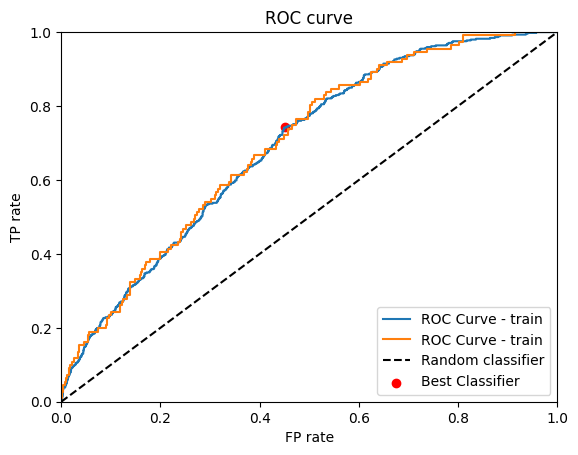

In [60]:
# simulations for Logistic Regression
data = pd.read_csv("dados_hospital.csv", sep=',')
data.dropna(inplace=True)
target = 'no_show'
mapeamento = {'SIM': 0, 'NÃO': 1}
data[target] = data[target].map(mapeamento).astype(int)
data = data[data["distance"]<1000]
original_columns = list(data.columns[:-1])
categoricalvar = {cl:data[cl].dtypes == np.object0 for cl in original_columns} 
categs = categorizar(data=data,columns=[cl for cl in original_columns if not categoricalvar[cl]])
data = categs["data"]

encodar = [cl for cl in original_columns if categoricalvar[cl]]+[f"{cl}_cat" for cl in original_columns if not categoricalvar[cl]]
encodado = meu_enconder(data=data,columns=encodar,target=target,split=False)

data = encodado["data"]
res = significancia(data,categoricalvar,target)
predictors = res["significantes"]

from itertools import product
grau = [1,2]
escala = [MinMaxScaler(),StandardScaler()]
# regu = [10**(-i) for i in range(-1,20,3)]
regu = [50,10,1, 0.1, 0.01, 0.001]
regu = np.geomspace(0.01,10,20)

combinations = list(product(grau, escala,regu))

simulacoes =  pd.DataFrame()
for k,v in enumerate(combinations):
    print(f"modelo {k+1} de {len(combinations)} ",end='\r')
    pipe = Pipeline([('poly',PolynomialFeatures(v[0])),('escala',v[1]),('modelo', LogisticRegression(penalty='l2',C = v[2],class_weight='balanced',max_iter=1000000))])
    res = simulador(pipe,data,predictors,target,50)
    simulacoes[f"sim_{k+1}"] = res["geo_score"]

analise_sim = minha_anova(simulacoes.to_numpy().T,alpha=0.05)

data_train,data_test = train_test_split(data,test_size=0.2, stratify=data[target])
X_train,y_train = data_train[predictors],data_train[target]
X_test,y_test = data_test[predictors],data_test[target]
my_scorer,my_scorer_m = make_scorer(roc_auc_score,greater_is_better=True), make_scorer(minha_metrica,greater_is_better=True)


idx = simulacoes.median().argmax()
esc = analise_sim["stats"][idx]["igual_idx"][0]
v = combinations[esc]
pipe = Pipeline([('poly',PolynomialFeatures(v[0])),('escala',v[1]),('modelo', LogisticRegression(penalty='l2',C = v[2],class_weight='balanced',max_iter=1000000))])
search = cross_validate(pipe, X_train, y_train, scoring=my_scorer, cv=7, return_estimator=True)
bests = search['estimator'][np.argmax(search['test_score'])]

y_pred_test = bests.predict_proba(X_test)[:,1]
y_pred_train = bests.predict_proba(X_train)[:,1]


res = get_scores(y_train,y_pred_train,y_test,y_pred_test,scorers=[minha_metrica_c,accuracy_score,f1_score,roc_auc_score,recall_score,precision_score])
print(f"{res['metricas']}\n")
print(f"{res['confusion_matrix']}\n")
curva_test = res["roc_curve_test"]
curva_train = res["roc_curve_train"]
melhor = res["melhor"]
plt.plot(curva_train["fpr"], curva_train["tpr"], label='ROC Curve - train')
plt.plot(curva_test["fpr"], curva_test["tpr"], label='ROC Curve - train')
plt.plot([0, 1], [0, 1], color = 'k', ls = 'dashed', label='Random classifier')
plt.scatter(melhor[0],melhor[1],label='Best Classifier',color = 'red')
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

[(1, MinMaxScaler(), 1.623776739188721),
 (2, StandardScaler(), 0.26366508987303583)]

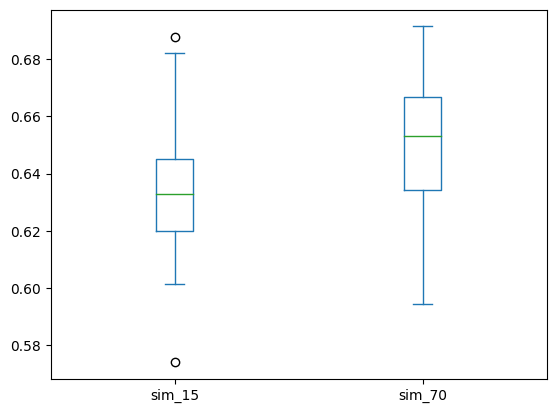

In [61]:
lst = analise_sim["stats"][idx]["igual_idx"]
simulacoes[[f"sim_{i+1}" for i in [esc,idx]]].plot.box()
[combinations[i] for i in [esc,idx]]

In [270]:
def agrupa_predicoes(estimator,data_train,data_test,predictors,categoricalvar,corte):
    X_train,y_train = data_train[predictors],data_train[target]
    # X_test,y_test = data_test[predictors],data_test[target]

    # y_pred_test = estimator.predict_proba(X_test)[:,1]
    y_pred_train = estimator.predict_proba(X_train)[:,1]


    data_train["compara"]=((y_pred_train>=corte)==y_train).astype(int)
    res_stat={}
    pred_sep = []
    for cl in predictors:
        if categoricalvar[cl]:
            contingency_table = pd.crosstab(data_train[cl], data_train["compara"])
            chi2, p, _, _ = chi2_contingency(contingency_table)
            res_stat[cl]=[p, p<0.05]
            if p<0.05:
                pred_sep.append(cl)
        else:
            groups = []
            gpstat = data_train.groupby("compara")
            for k in gpstat.groups.keys():
                groups.append(gpstat.get_group(k)[cl])
            f_statistic, p = kruskal(*groups)
            res_stat[cl]=[p, p<0.05]
            if p<0.05:
                pred_sep.append(cl)
    
    pred_sep.append("compara")

    # pred_sep = ["month","no_exa_scheduled_previous_year","compara"]
    normalizador = data_train[pred_sep[:-1]].max().to_numpy() 
    normalizador = np.ones(shape=(len(pred_sep[:-1]),))
    g_tr_comp = data_train[pred_sep].groupby("compara")
    train_0_m = g_tr_comp.get_group(0).mean().to_numpy()[:-1]/normalizador
    train_1_m = g_tr_comp.get_group(1).mean().to_numpy()[:-1]/normalizador
    
    separa = []
    for y in data_test.index:
        x = data_test[pred_sep[:-1]].loc[y,:].to_numpy()/normalizador
        n0 = np.linalg.norm(x-train_0_m,4)
        n1 = np.linalg.norm(x-train_1_m,4)
        separa.append(0*(n1>=n0)+1*(n1<n0))

    data_test["separa"] = separa

    X_train_0 = data_train.groupby("compara").get_group(0)[predictors]
    X_train_1 = data_train.groupby("compara").get_group(1)[predictors]
    
    y_train_0 = data_train.groupby("compara").get_group(0)[target]
    y_train_1 = data_train.groupby("compara").get_group(1)[target]
    
    X_test_0 = data_test.groupby("separa").get_group(0)[predictors]
    X_test_1 = data_test.groupby("separa").get_group(1)[predictors]
    
    y_test_0 = data_test.groupby("separa").get_group(0)[target]
    y_test_1 = data_test.groupby("separa").get_group(1)[target]

    y_pred_train_0 = estimator.predict_proba(X_train_0)[:,1]
    y_pred_train_1 = estimator.predict_proba(X_train_1)[:,1]
    
    y_pred_test_0 = estimator.predict_proba(X_test_0)[:,1]
    y_pred_test_1 = estimator.predict_proba(X_test_1)[:,1]
    
    roc_esc_ts_1 = roc_auc_score(y_test_1,y_pred_test_1)
    roc_esc_ts_0 = roc_auc_score(y_test_0,y_pred_test_0)
    
    roc_esc_tr_1 = roc_auc_score(y_train_1,y_pred_train_1)
    roc_esc_tr_0 = roc_auc_score(y_train_0,y_pred_train_0)
    
    fpr_tr0,tpr_tr0,_ = roc_curve(y_train_0,y_pred_train_0)
    fpr_tr1,tpr_tr1,_ = roc_curve(y_train_1,y_pred_train_1)
    
    fpr_ts1,tpr_ts1,_ = roc_curve(y_test_1,y_pred_test_1)
    fpr_ts0,tpr_ts0,_ = roc_curve(y_test_0,y_pred_test_0)

    curvas_roc = {"train_0":[fpr_tr0,tpr_tr0],"train_1":[fpr_tr1,tpr_tr1],"test_0":[fpr_ts0,tpr_ts0],"test_1":[fpr_ts1,tpr_ts1]}
    metrs = {"train_0":roc_esc_tr_0,"train_1":roc_esc_tr_1,"test_0":roc_esc_ts_0,"test_1":roc_esc_ts_1}
    return {"data":{"train":data_train,"test":data_test},"curva_roc":curvas_roc,"metricas":metrs,"separador":pred_sep}



In [271]:
corte = res["melhor"][2]
agrupado = agrupa_predicoes(bests,data_train,data_test,predictors,categoricalvar,corte)

[1. 1. 1. 1. 1. 1. 1.]


In [272]:
agrupado["metricas"]

{'train_0': 0.0,
 'train_1': 1.0,
 'test_0': 0.5383563589871081,
 'test_1': 0.8229310055397012}

In [233]:
agrupado["separador"]

['race',
 'marital_status',
 'schooling',
 'month',
 'no_ns_cons_previous_year',
 'no_exa_scheduled_previous_year',
 'no_ns_exa_previous_year',
 'compara']

In [235]:
data_train[agrupado["separador"]].max()

race                               4
marital_status                     5
schooling                          6
month                             11
no_ns_cons_previous_year          19
no_exa_scheduled_previous_year    48
no_ns_exa_previous_year            9
compara                            1
dtype: int64